In [1]:
#Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from glob import glob
import os
import warnings
pd.options.mode.chained_assignment = None

In [2]:
#Defining the path and the extension of the required files
PATH = "./2020/"
EXT = "*.csv"
#Fetching and storing the names of the required files in all_csv_files
all_csv_files = []
for path, subdir, files in os.walk(PATH):
    for file in glob(os.path.join(path, EXT)):
        all_csv_files.append(file)

In [3]:
#Checking if all files are fetched
all_csv_files

['./2020\\dc_epa_2020.csv',
 './2020\\dc_sense_2020.csv',
 './2020\\howard_epa_2020.csv',
 './2020\\howard_sense_2020.csv']

In [4]:
def drop_col(x):
    """Drop the unnecessary columns in EPA dataframe (has no effect on SENSE dataframe)"""
    if('State Code' in x.columns):
                x.drop(['State Code', 'Datum', 'Parameter Name', 'Date GMT', 'Time GMT', 'Units of Measure',
                     'County Code', 'Site Num', 'Parameter Code', 'POC', 'Latitude', 'Longitude', 'MDL', 
                     'Method Type', 'Method Name', 'State Name', 'County Name', 'Date of Last Change', 
                     'Uncertainty', 'Qualifier', 'Method Code'], axis = 1, inplace = True)
    return x

In [5]:
def remove_negative(x):
    """Return the SENSE or EPA dataframe with the negative PM2.5 values removed."""
    if('Sample Measurement' in x.columns):
        mask = x['Sample Measurement'] < 0
        x = x[~mask]
    else:
        mask = x['PM25'] < 0
        x = x[~mask]
    return x

In [6]:
def date_time(y):
    """Returns the SENSE or EPA dataframe with a new time column in the format YYYY-MM-DD HH:MM:SS."""
    if('Date Local' and 'Time Local' in y.columns):
        y['Time'] = (y['Date Local'] + " "
                     + y['Time Local']).apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %H:%M'))
        y.drop(['Date Local', 'Time Local'], axis = 1, inplace = True)
    else:
        y.rename(columns = {'data_time': 'Time'}, inplace = True)
        y['Time'] = y['Time'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    return y

In [7]:
def merge(x,y):
    """Merges the SENSE and EPA dataframe on their Time column, adds a new Error column which calculates the 
    absolute error, and renames the columns to identify the measurements taken by each sensor."""
    merged = pd.merge(x,y, on = 'Time')
    merged['Error'] = merged['Sample Measurement'] - merged['PM25']
    merged = merged.rename(columns = {'Sample Measurement' : 'EPA', 'PM25': 'SENSE'})
    return merged

In [8]:
def smoothen(x):
    """Calculates the rolling mean for both sensor measurements which will be used for a smoother plot."""
    x['SENSE(rolling mean)'] = x['SENSE'].rolling(24).mean()
    x['EPA(rolling mean)'] = x['EPA'].rolling(24).mean()
    x = x[23:]
    return x

In [9]:
def plot(x,n):
    """Plots two subplots: one with the regular PM 2.5 values and the other with rolling mean PM 2.5 values. """
    fig, axes = plt.subplots(nrows=2, ncols=1)
    x.plot(x = "Time", y = ["SENSE", "EPA"], figsize = (15,4), ax=axes[0])
    x.plot(x="Time", y=["SENSE(rolling mean)", "EPA(rolling mean)"], figsize = (15,4), ax=axes[1], sharex = axes[0])
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('PM2.5(µg/m3)')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('PM2.5(µg/m3)')
    fig.tight_layout()
    fig.suptitle("EPA and SENSE Sensor Measurements of PM 2.5 at " + n, y = 1.04)

In [10]:
#Preprocessing for the individual datasets
list_df = {}
dfs = ('epa_dc','sense_dc', 'epa_howard', 'sense_howard')
for d,f in zip(dfs,all_csv_files):
    list_df[d] = pd.read_csv(f)
    list_df[d] = list_df[d].pipe(drop_col).pipe(remove_negative).pipe(date_time)

In [11]:
#Merging the EPA and SENSE dataframes for each location
dc = merge(list_df['epa_dc'], list_df['sense_dc'])
howard = merge(list_df['epa_howard'], list_df['sense_howard'])

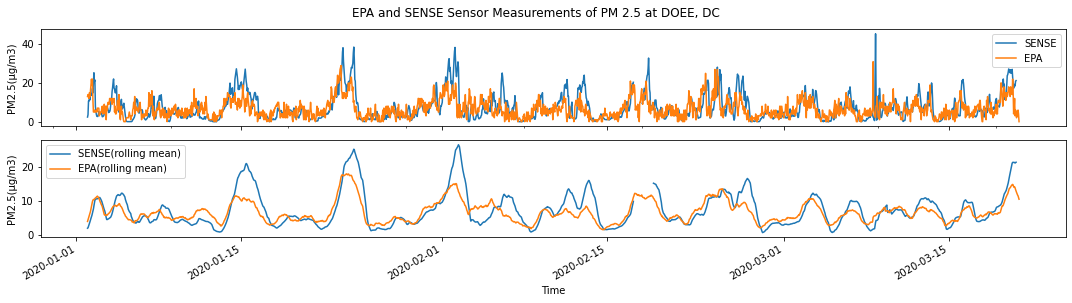

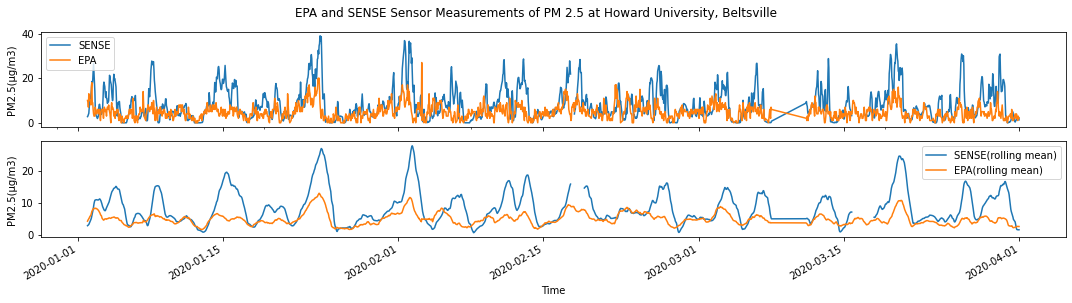

In [12]:
#Plotting the graphs
for x,y in zip([dc, howard], ["DOEE, DC", "Howard University, Beltsville"]):
    x.pipe(smoothen).pipe(plot, y)